In [1]:
# Imports
import sys  
sys.path.insert(0, 'C:\\Users\\espebh\\Documents\\Project\\code\\post_processing')
import cv2
import numpy as np
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import math
from draw_utils import draw_label_on_single_img, draw_active_tracker
from track_utils import bb_intersection_over_union, update_trackers
from scipy.signal import butter, lfilter
import pickle
import os
import pandas as pd
import math
import datetime

In [2]:
# Create macros
DEVICE = torch.device('cpu')
FRAMES_PER_SECOND = 60


In [7]:
# Load model
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(weights=None,
                                                               weights_backbone=True,
                                                               num_keypoints=3,
                                                               num_classes = 2)
model.load_state_dict(torch.load(r"C:\Users\espebh\Documents\Project\model\\salmon_keypoint_detection_10_epoch", map_location=DEVICE))
model.to(DEVICE).eval()

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [8]:
# Initialize visualization loop
# When the mp4 movies hit some frames, they are unable to read further. Therefore, we start some frames into the video.
# For 2t tank 9.mp4, the problematic frame is 45
# Broken frame is used in case a new frame is creating problems. Then, num_broken_frames tries to read/jump some times before ending the stream
start_frame = 5000
num_broken_frames = 0
num_frames_in_video = 1000

# Define video to read
video_in = cv2.VideoCapture(r'C:\\Users\\espebh\\Documents\\Project\\data\\videos\\4t tank 9.mp4')
print("Number of frames: " + str(video_in.get(cv2.CAP_PROP_FRAME_COUNT)))
video_in.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Define where to write the video
date = datetime.datetime.now()
save_path = "C:\\Users\\espebh\\Documents\\Project\\Results\\"
mov_txt = 'Test run ' + '4t_t9 ' + 'f_' + str(start_frame) + '_' + str(start_frame + num_frames_in_video) + ' '
ID = str(date.year) + str(date.month) + str(date.day) + str(date.hour) + str(date.minute)
movie_name = mov_txt + ID
video_out = cv2.VideoWriter(save_path + movie_name + '.avi', cv2.VideoWriter_fourcc(*'mp4v'), 100.0, (1600, 800), True)
print('Saving to: ' + movie_name)

# Initialize trackers for logging fish
active_tracker = []
log_tracker = []
box_count = 0

Number of frames: 42420.0
Saving to: Test run 4t_t9 f_5000_6000 20221214927


In [9]:
# Create a video with keypoint and bbox annotations

while True:
    suc, img = video_in.read() # Read video frame
    if suc:
        # Transform image to a valid neural network input
        img = cv2.resize(img, (1600, 800), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        img_tensor = torchvision.transforms.functional.pil_to_tensor(img_pil)
        img_tensor = torch.div(img_tensor, 255)

        # Pass frame through neural network
        output = model([img_tensor])

        # Track fish, log keypoint distances
        active_tracker, log_tracker, box_count = update_trackers(active_tracker, log_tracker, video_in.get(cv2.CAP_PROP_POS_FRAMES), output, box_count)

        # Annotate image 
        #img = draw_label_on_single_img(img_tensor, output[0])
        img = draw_active_tracker(img_tensor,active_tracker)

        # Save frame
        video_out.write(img)
    else:
        # If the capture object cannot read a frame, try to jump forward
        num_broken_frames = num_broken_frames + 1
        video_in.set(cv2.CAP_PROP_POS_FRAMES, video_in.get(cv2.CAP_PROP_POS_FRAMES)+5)

    # Print number of frames
    print("Number of frames: " + str(video_in.get(cv2.CAP_PROP_POS_FRAMES)))

    # Exit loop if we have enough frames, or reached the end of the video
    if num_broken_frames > 20:
        break
    if video_in.get(cv2.CAP_PROP_POS_FRAMES) > start_frame + num_frames_in_video:
        break

# Release capture object and windows
video_in.release()
video_out.release()
cv2.destroyAllWindows()
print("The video was successfully saved")

Number of frames: 5001.0
Number of frames: 5002.0
Number of frames: 5003.0
Number of frames: 5004.0
Number of frames: 5005.0
Number of frames: 5006.0
Number of frames: 5007.0
Number of frames: 5008.0
Number of frames: 5009.0
Number of frames: 5010.0
Number of frames: 5011.0
Number of frames: 5012.0
Number of frames: 5013.0
Number of frames: 5014.0
Number of frames: 5015.0
Number of frames: 5016.0
Number of frames: 5017.0
Number of frames: 5018.0
Number of frames: 5019.0
Number of frames: 5020.0
Number of frames: 5021.0
Number of frames: 5022.0
Number of frames: 5023.0
Number of frames: 5024.0
Number of frames: 5025.0
Number of frames: 5026.0
Number of frames: 5027.0
Number of frames: 5028.0
Number of frames: 5029.0
Number of frames: 5030.0
Number of frames: 5031.0
Number of frames: 5032.0
Number of frames: 5033.0
Number of frames: 5034.0
Number of frames: 5035.0
Number of frames: 5036.0
Number of frames: 5037.0
Number of frames: 5038.0
Number of frames: 5039.0
Number of frames: 5040.0


In [10]:
# Save trackers
log_file = open(save_path + 'log_file_' + movie_name + '.pkl', 'wb')
pickle.dump(active_tracker + log_tracker, log_file)
log_file.close()

In [11]:
# Load saved tracker
log_file = open(save_path + 'log_file_' + movie_name + '.pkl', 'rb')
loaded_tracker = pickle.load(log_file)

In [12]:
# Import ground truth from disk
# [[box numbers],[first registered peak jaw gape],[second registered peak jaw gape], ...]
# Extract box number by df.columns.values

gt = False

if gt:
    df = pd.read_excel(save_path + movie_name + '\\annotation.xlsx')
    ground_truth = []

    # Iterate over all boxes, and store statistics to list of dictionaries
    for index, row in df.iteritems():
        vals = row.dropna().to_numpy()
        freqs = np.array(([FRAMES_PER_SECOND/(vals[i+1]-vals[i]) for i in range(len(vals)-1)]))
        avg = sum(freqs)/len(freqs)
        if len(freqs) > 1:
            std = math.sqrt(np.sum(np.power((freqs-avg), 2))/(len(freqs)-1))
        else:
            std=-1
        ground_truth.append({'box': index, 'freqs': freqs, 'std': round(std, 4), 'average': round(avg, 4)})

In [13]:
# Set tresholds.
# amp_tresh: Any point that is further away than treshold from the average of the last two points will receive the value of the average of the last two points
# len_tresh_low: Any fish that are registered for less than treshold number of frames will be removed
# len_tresh_high: Maximum number of frames for each fish registration
# nneighbors: The number of previous points that are averaged over when performing outlier rejection
import copy
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

len_tresh_low = 50
len_tresh_high = 120
amp_tresh = 10
nneighbors = 3

# Remove too short trackers
val_trackers_mod = copy.deepcopy([tracker for tracker in loaded_tracker if len(tracker['dists'])>len_tresh_low])

# Split trackers with long dists into i trackers with lengths len_tresh_high and one tracker with length between len_tresh_low and len_tresh_high.
split_trackers = []
for tracker in val_trackers_mod:
    dists = tracker['dists']
    if len(dists)//120>0:
        for i in range(0, (len(dists)//len_tresh_high)):
            tracker_short = {}
            tracker_short['dists'] = dists[(i)*len_tresh_high:(i+1)*len_tresh_high]
            tracker_short['first_frame'] = tracker['first_frame'] + i*len_tresh_high
            tracker_short['box_count'] = tracker['box_count']
            split_trackers.append(tracker_short)
        if len(dists)%len_tresh_high > len_tresh_low:
            tracker_short = {}
            tracker_short['dists'] = dists[len(dists)-len(dists)%len_tresh_high:-1]
            tracker_short['first_frame'] = tracker['first_frame'] + (i+1)*len_tresh_high
            tracker_short['box_count'] = tracker['box_count']
            split_trackers.append(tracker_short)
    else: split_trackers.append(tracker)

# Remove outliers
for tracker in split_trackers:
    for i in range(2,len(tracker['dists'])):
        avg = sum(tracker['dists'][i-nneighbors:i])/nneighbors
        if abs(avg-tracker['dists'][i]) > amp_tresh:
            tracker['dists'][i] = avg

processed_trackers = copy.deepcopy(split_trackers)
print('Number of trackers: ', len(processed_trackers))


Number of trackers:  22


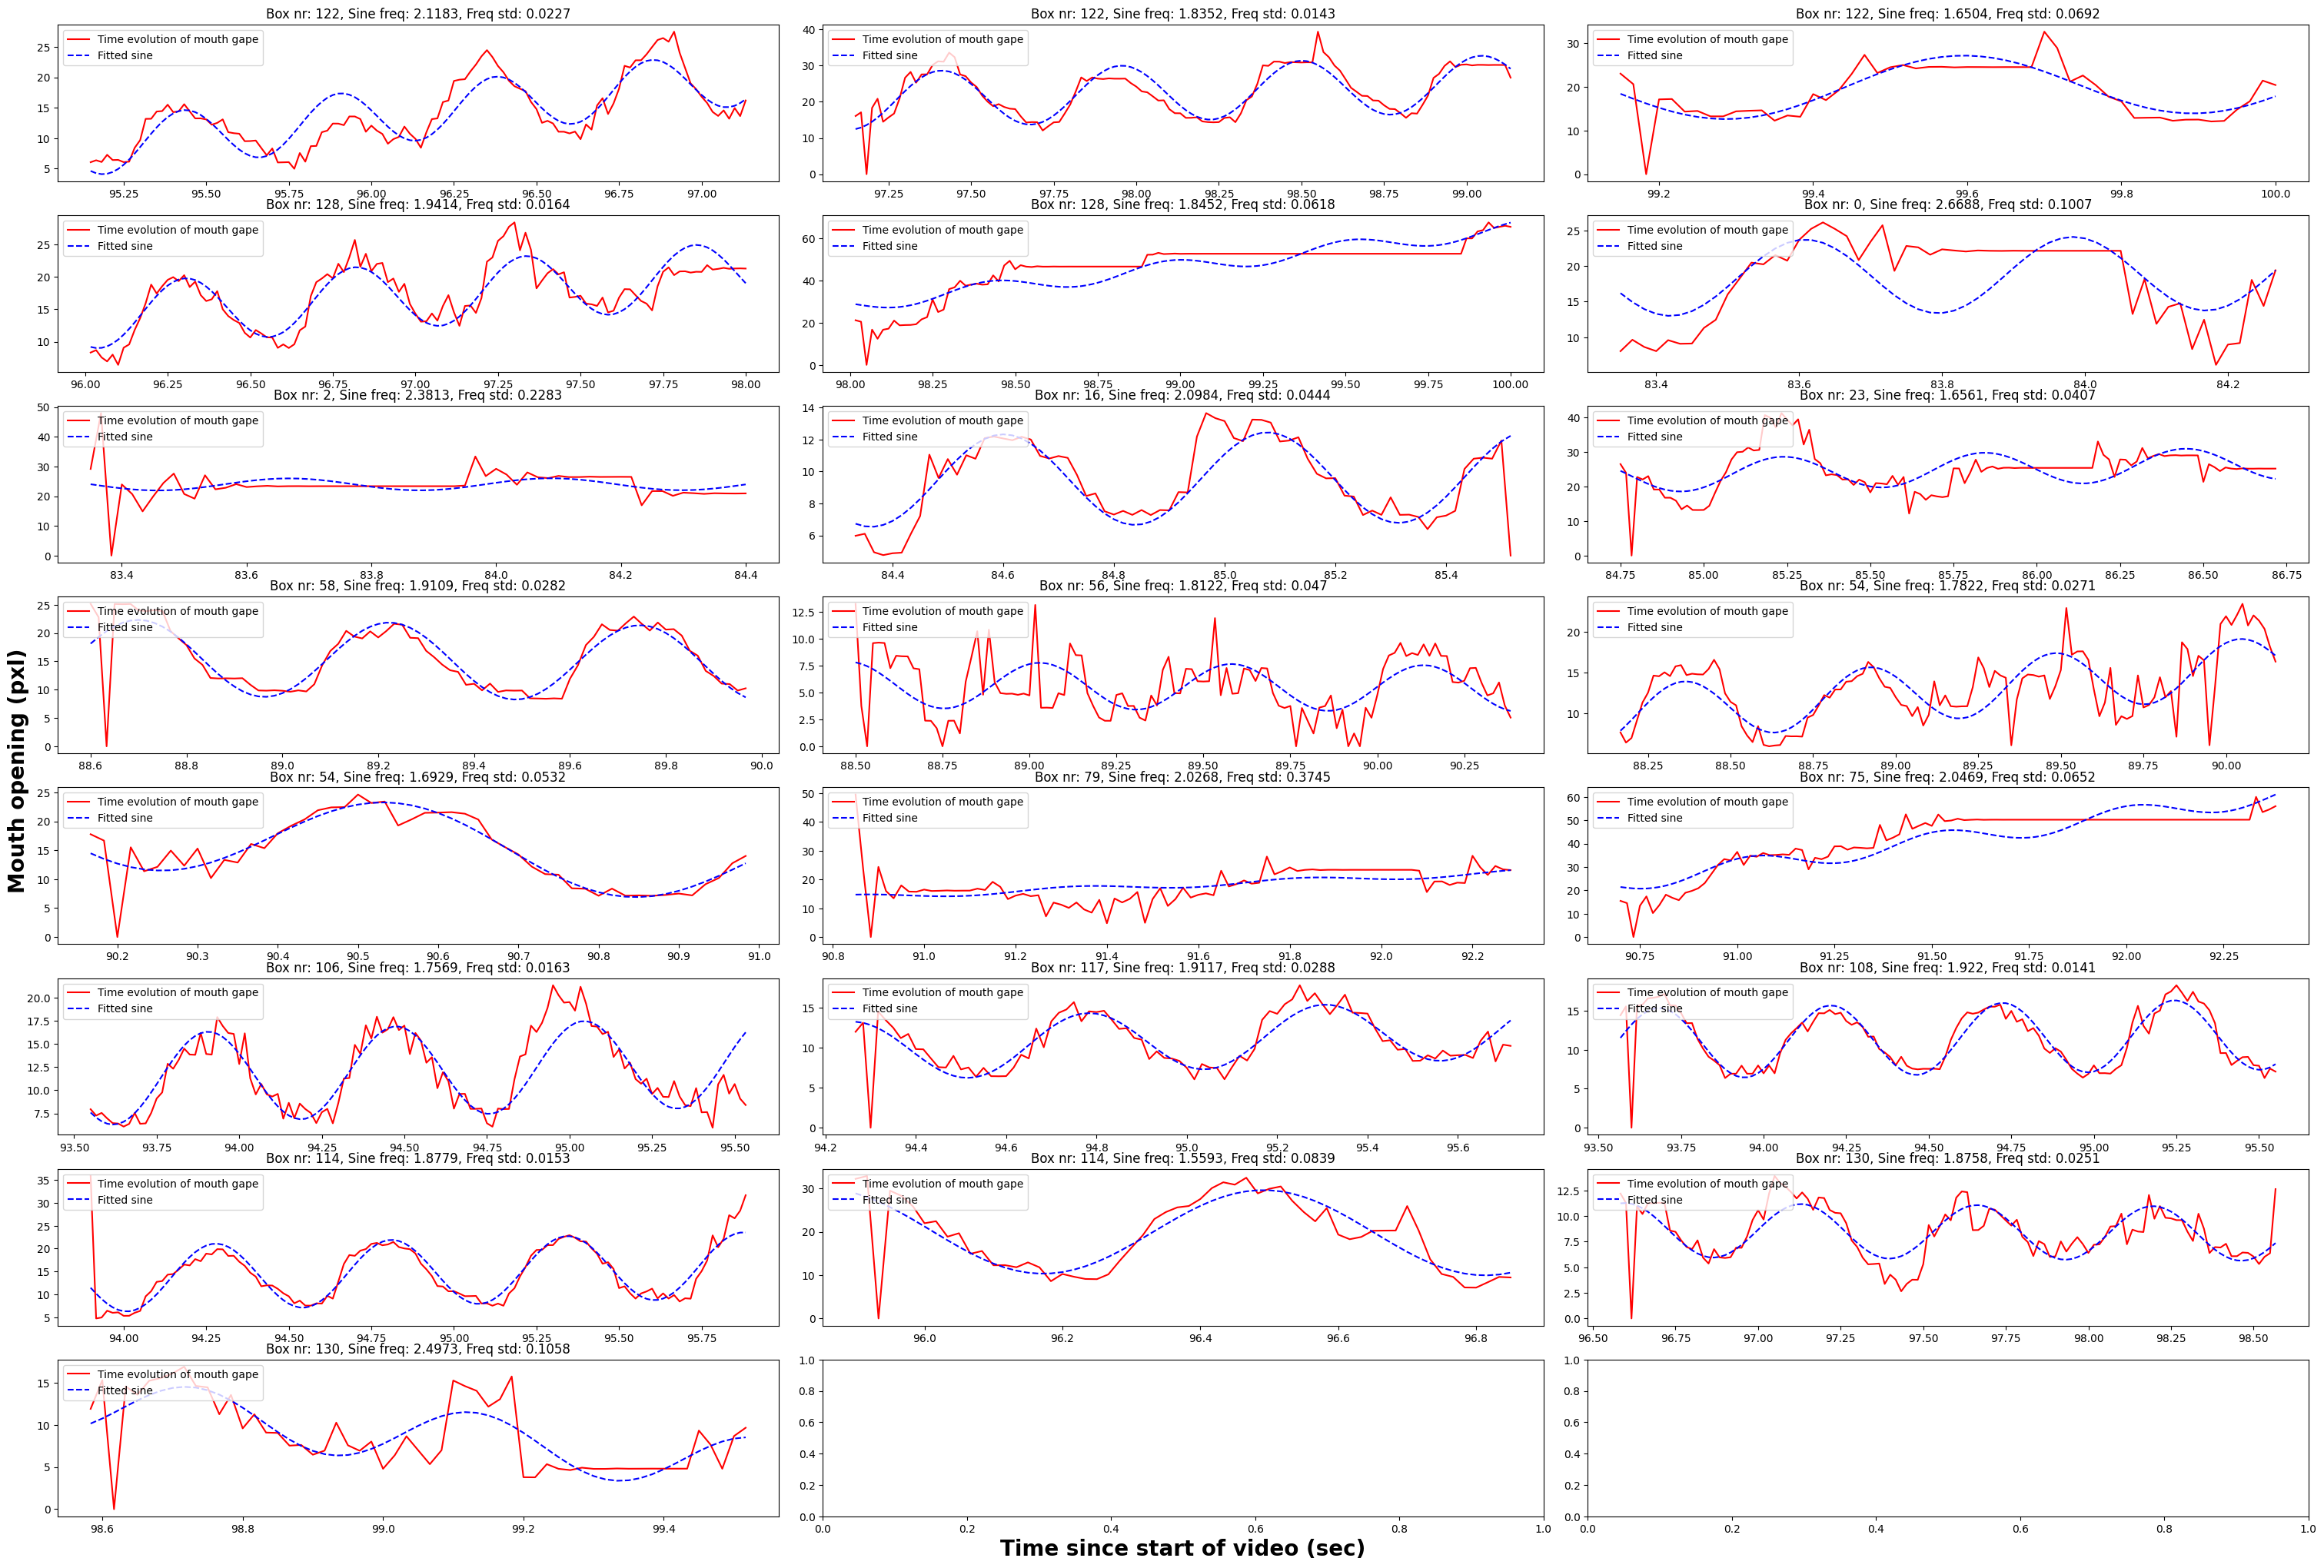

In [14]:
from sig_proc_utils import butter_highpass_filter, butter_bandpass_filter
import pylab as pl
from scipy.optimize import curve_fit

# Plot time evolution
# Choose layout and initialize figures
num_col = 3
fig, ax = plt.subplots(nrows=int(len(processed_trackers)/num_col)+1, ncols = num_col, figsize=(30,20))
fig.tight_layout()

# Initialize sine frequencies
y_sine_freq = []
y_sine_perr = []

# Iterate over all fish
for row in range(int(len(processed_trackers)/num_col)+1):
    for col in range(num_col):
        # Sunchronize ploting table and linear list of fish
        tracker = row*num_col+col
        if tracker >= len(processed_trackers): 
            break
        # Extract distances
        y = processed_trackers[tracker]['dists']
                
        # Extract time values
        x = np.array(range(int(processed_trackers[tracker]['first_frame']), int(processed_trackers[tracker]['first_frame']) + len(processed_trackers[tracker]['dists'])))/FRAMES_PER_SECOND
        
        # Initialize sinusoid
        N = len(y)
        freq0 = 2           # Frequency of sine in Hz
        amp0 = np.sqrt(2)*np.std(y)  # Amplitude of sine in pxl
        phase0 = 0          # Phase of sine in Hz
        offset0 = np.mean(y)# Offset of sine in pxl
        a0 = 0              # linear weight of signal in pxl/sec
        p0=[freq0, amp0, phase0, offset0, a0]

        # Define and fit sine
        def my_sin(x, freq, amp, phase, offset, a):
            return (np.sin(x * freq*(2*np.pi) + phase) * amp + offset) + a*x
        popt, pcov = curve_fit(my_sin, x, y, p0=p0, maxfev=5000)
        perr = np.sqrt(np.diag(pcov))

        # Extract time evolution of sine and save frequency and amplitude
        y_sine = my_sin(x, *list(popt))
        y_sine_freq.append(popt[0]) 
        y_sine_perr.append(perr[0])

        # Plot timeseries
        ax[row][col].set_title('Box nr: ' + str(processed_trackers[tracker]['box_count']) + ', Sine freq: ' + str(round(y_sine_freq[-1], 4)) + ', Freq std: ' + str(round(y_sine_perr[-1], 4)))
        ax[row][col].plot(x, y, 'r', label='Time evolution of mouth gape')
        ax[row][col].plot(x, y_sine, label='Fitted sine', color = 'b', linestyle = 'dashed')
        ax[row][col].legend(loc='upper left')
        
fig.add_subplot(1, 1, 1, frame_on=False)

# Hiding the axis ticks and tick labels of the bigger plot
plt.tick_params(labelcolor="none", bottom=False, left=False)

# Adding the x-axis and y-axis labels for the bigger plot
plt.xlabel('Time since start of video (sec)', fontsize=20, fontweight='bold')
plt.ylabel('Mouth opening (pxl)', fontsize=20, fontweight='bold')
plt.show()

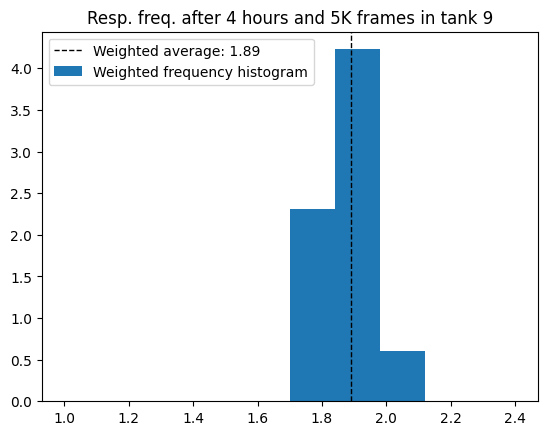

Number of valid trackers:  10
[2.11825888 1.83515592 1.94138205 1.91093629 1.78221184 1.75692978
 1.91167894 1.92195    1.87788123 1.87581762]


In [16]:
# Plot weighted histogram of breathing frequencies
# All frequencies with frequency standard deviation over err_tresh are removed.
# The weights are the inverse of the frequency standard deviation

err_tresh = 0.04
idx = np.array(y_sine_perr)<err_tresh
avg = np.average(np.array(y_sine_freq)[idx], weights= 1/(np.array(y_sine_perr)[idx]))

plt.hist(np.array(y_sine_freq)[idx], weights = 1/(np.array(y_sine_perr)[idx]), density = True, range = (1,2.4))
plt.title('Resp. freq. after 4 hours and 5K frames in tank 9')
plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
plt.legend(['Weighted average: ' + str(round(avg, 2)), 'Weighted frequency histogram'])
plt.show()

print('Number of valid trackers: ', len(np.array(y_sine_freq)[idx]))
print(np.array(y_sine_freq)[idx])

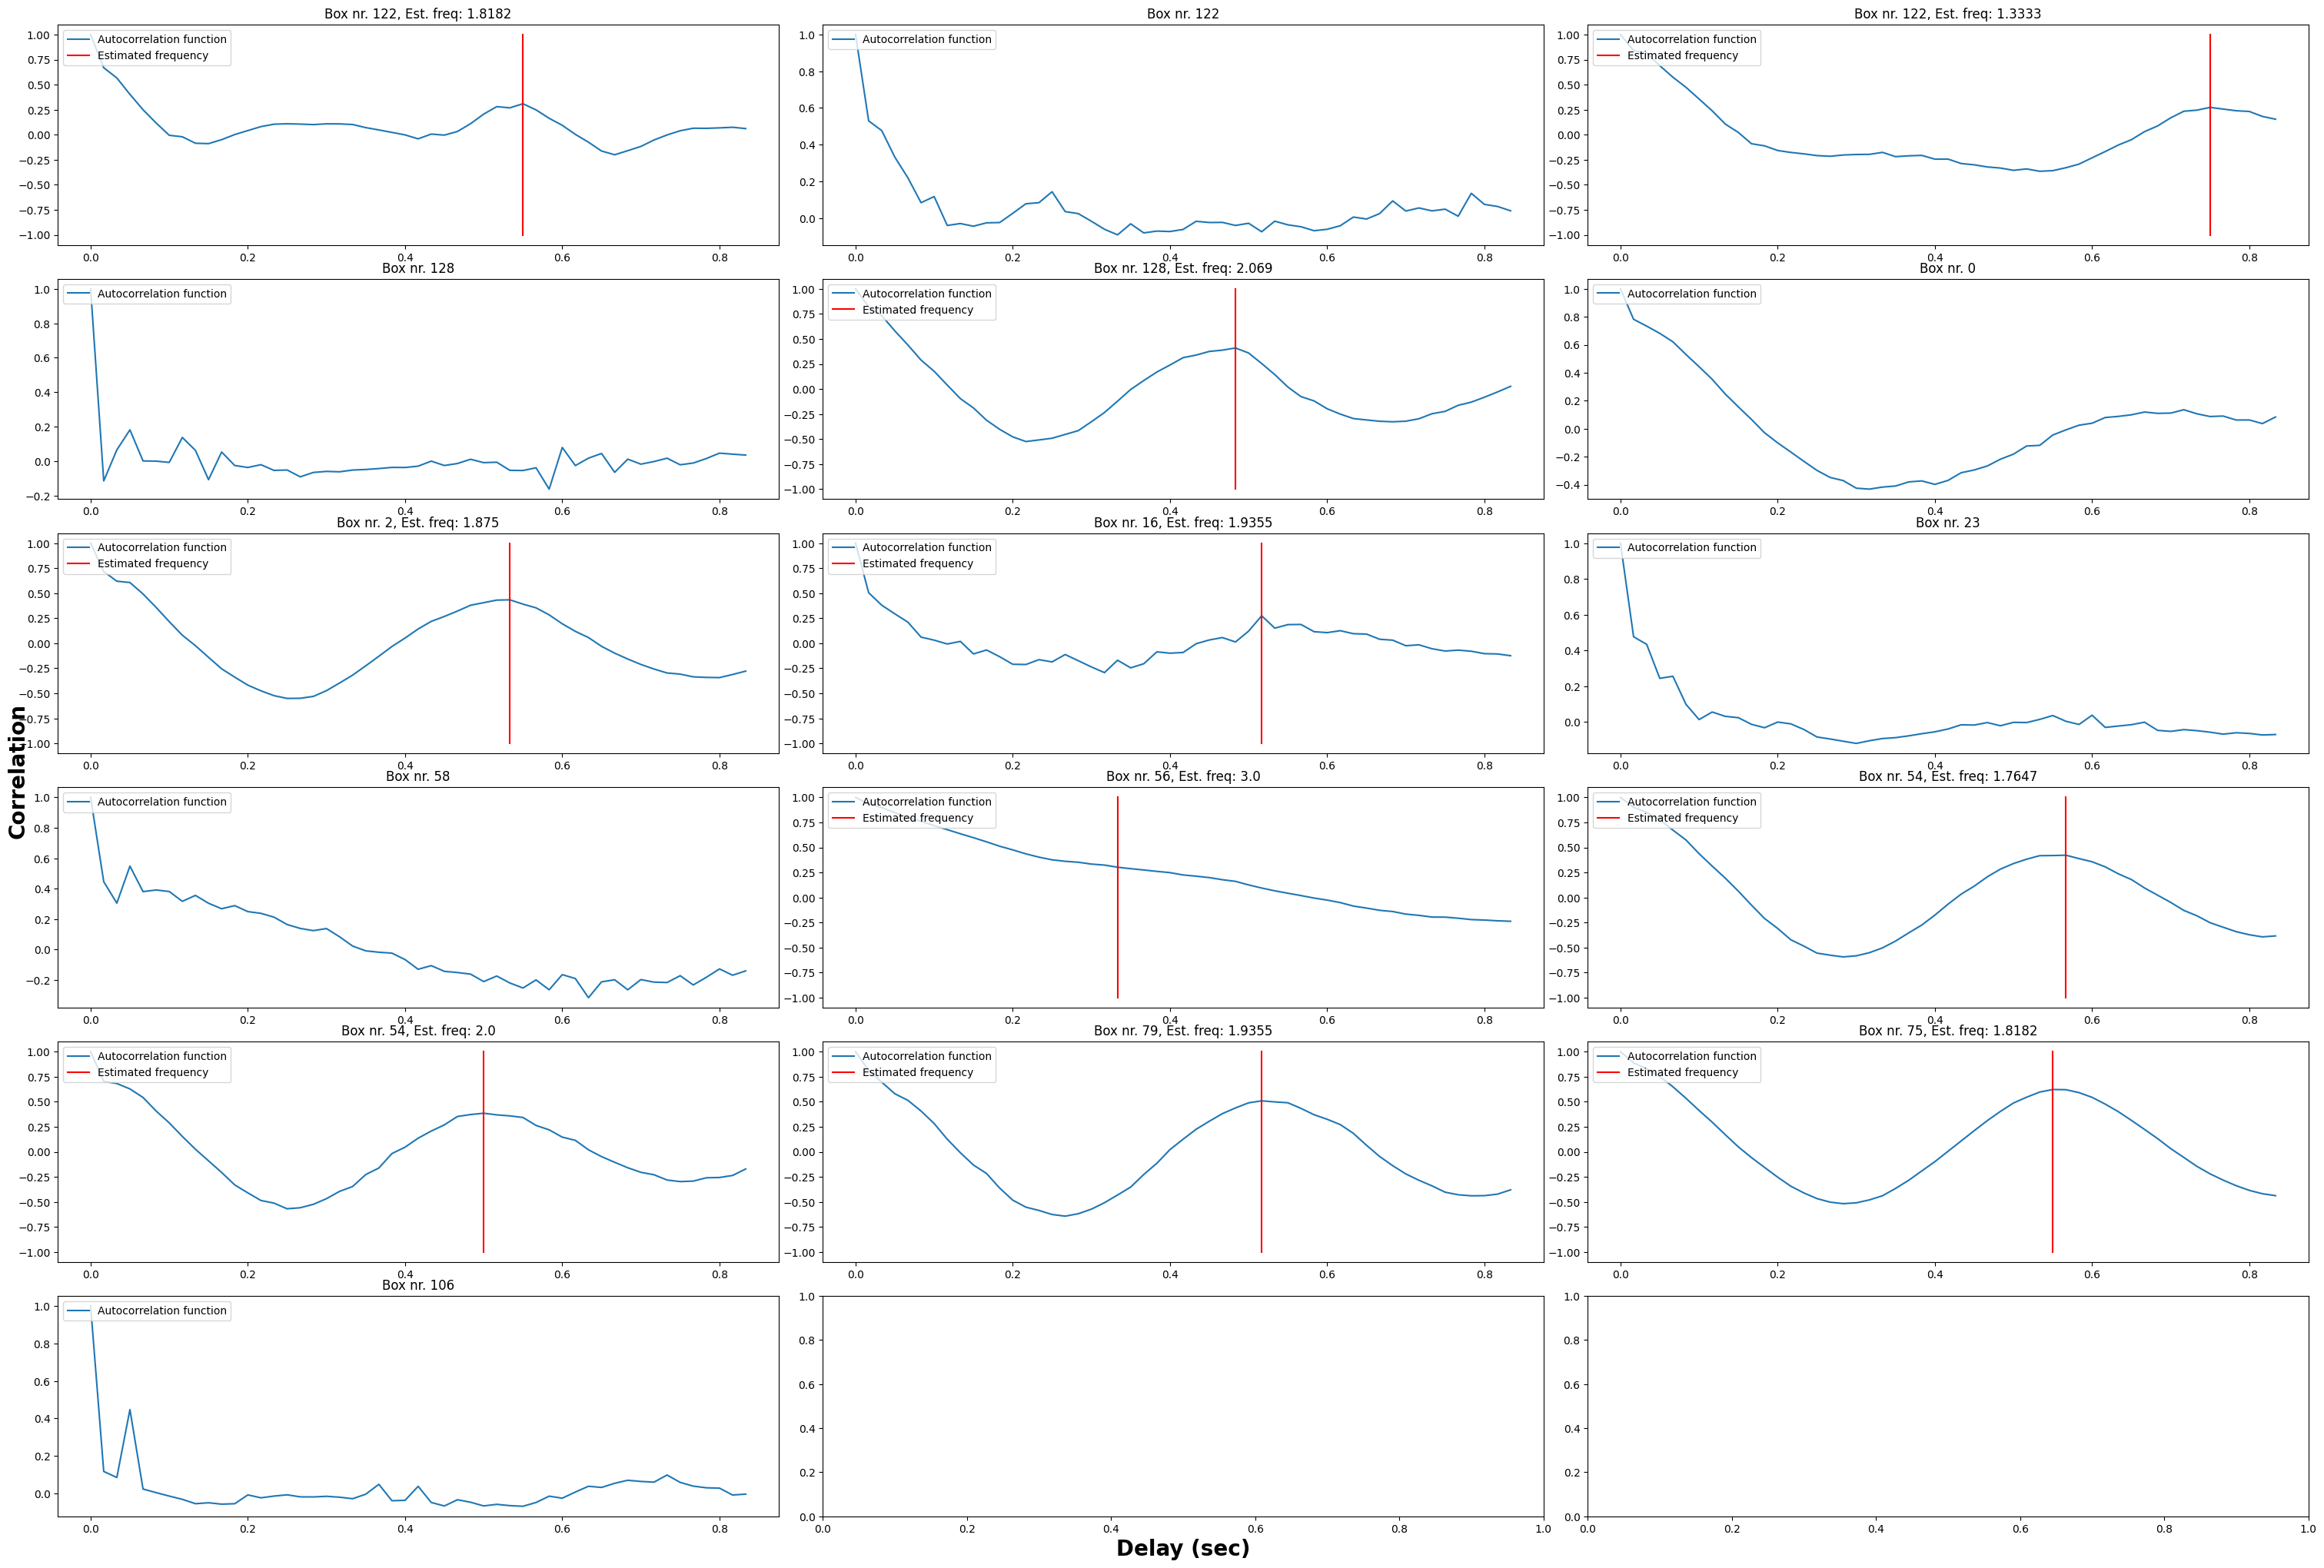

In [17]:
# Plot auto correlation
from statsmodels.graphics.tsaplots import plot_acf, acf

# Define parameters
# autocorr_cutoff = 0.2: The minimum amount of correlation to be considered a valid salmon frequency
# low_delay_cutoff: The number of frames before starting looking for correlation
fs = FRAMES_PER_SECOND
num_col = 3
autocorr_cutoff = 0.15
low_delay_cutoff = 20
gt = False

# Initialize plot grid
fig, ax = plt.subplots(nrows=int(len(val_trackers_mod)/num_col)+1, ncols = num_col, figsize=(30,20))
fig.tight_layout()

# Iterate over all fish
for row in range(int(len(val_trackers_mod)/num_col)+1):
    for col in range(num_col):
        # Synchronize plotting table and linear list of fish
        tracker = row*num_col+col
        if tracker >= len(val_trackers_mod):
            break
        # Extract ground truth
        avg = -1
        std = -1
        if gt:
            for fish in ground_truth:
                if fish['box'] == processed_trackers[tracker]['box_count']:
                    avg = fish['average']
                    std = fish['std']
                    ax[row][col].plot((1/avg, 1/avg), (-1, 1), scaley = True, color = 'b', linestyle = 'dashed', label='GT frequency')
        # Find autocorrelation of the jaw opening evolution of the fish
        y_mod = val_trackers_mod[tracker]['dists']
        x_autocorr =np.array(range(51))/60
        acf_inst = acf(np.array(y_mod), nlags=min(len(y_mod)-1, 50)) 
        # Find the maximum and the position of the maximum of the autocorrelation
        max = np.max(acf_inst[20:])
        argmx = np.argmax(acf_inst[20:])
        # Plot autocorrelation and where the autocorrelation has its maximum
        ax[row][col].plot(x_autocorr, acf_inst, label = 'Autocorrelation function')
        if max > autocorr_cutoff:
            ax[row][col].plot(((argmx+20)/FRAMES_PER_SECOND, (argmx+20)/FRAMES_PER_SECOND), (-1, 1), scaley = True, color = 'r', label='Estimated frequency')
            if gt: 
                ax[row][col].set_title('Box nr. ' + str(processed_trackers[tracker]['box_count']) + ', Est. freq: ' + str(round(1/((argmx+20)/FRAMES_PER_SECOND), 4)) + ', GT avg freq: ' + str(avg) + ', GT std: ' + str(std))
            else:
                ax[row][col].set_title('Box nr. ' + str(processed_trackers[tracker]['box_count']) + ', Est. freq: ' + str(round(1/((argmx+20)/FRAMES_PER_SECOND), 4)))
        else:
            ax[row][col].set_title('Box nr. ' + str(processed_trackers[tracker]['box_count']))
        ax[row][col].legend(loc='upper left')
fig.add_subplot(1, 1, 1, frame_on=False)

# Hiding the axis ticks and tick labels of the bigger plot
plt.tick_params(labelcolor="none", bottom=False, left=False)

# Adding the x-axis and y-axis labels for the bigger plot
plt.xlabel('Delay (sec)', fontsize=20, fontweight='bold')
plt.ylabel('Correlation', fontsize=20, fontweight='bold')
plt.show()
